In [1]:
import sys
import torch

sys.path.append('../src')

from bearing_dataset import BearingDataset, Normalize
from catgan import Classifier, Generator

In [2]:
bearing_dataset = BearingDataset(type='A')
print('Loaded bearing dataset type ', bearing_dataset.get_type(), ' with ',
      bearing_dataset.get_cats_num(), ' categories, total ', len(bearing_dataset), ' samples ')


Loaded bearing dataset type  A  with  4  categories, total  3776  samples 


In [3]:
device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'

generator = Generator().to(device)
classifier = Classifier(cat_num = bearing_dataset.get_cats_num()).to(device)


In [4]:
optimizators = {
    'G': torch.optim.Adam(generator.parameters(), lr=0.001),
    'C': torch.optim.Adam(classifier.parameters(), lr=0.0001),   
}

losses = {
    'C': [],
    'G': []
}

In [5]:
from torch.utils.data import DataLoader

train_set, val_set = torch.utils.data.random_split(bearing_dataset, [len(bearing_dataset)*7//10, len(bearing_dataset)-len(bearing_dataset)*7//10])

K = bearing_dataset.get_cats_num()
N = 10
M = N*K

train_loader = DataLoader(train_set, batch_size=M, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False, drop_last=True)
len(train_loader), len(val_loader)

softmax = torch.nn.Softmax(dim=1)


In [12]:
## Supervised classifier training
from tqdm.notebook import tqdm

supervised_classifier = Classifier(cat_num = bearing_dataset.get_cats_num()).to(device)

supervised_optim = torch.optim.Adam(supervised_classifier.parameters(), lr=0.0001)

supervised_criterion = torch.nn.CrossEntropyLoss().to(device)

supervised_losses = []
supervised_classifier.train()

for epoch in range(100):
    for image, labelidx in tqdm(train_loader, desc = 'train loop', leave = True, disable = True):
        image = torch.unsqueeze(image,1).float()
        supervised_optim.zero_grad()
        image = image.to(device)
        out = supervised_classifier(image)
        target = torch.zeros(len(labelidx),bearing_dataset.get_cats_num())
        for idx, tv in enumerate(target):
            tv[labelidx[idx]]=1.
        supervised_loss = supervised_criterion(out, target.to(device))
        supervised_loss.backward()
        supervised_optim.step()
        supervised_losses.append(supervised_loss.item())

KeyboardInterrupt: 

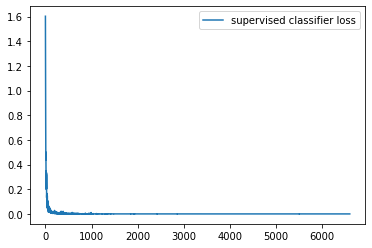

In [9]:
import matplotlib.pyplot as plt

plt.plot(supervised_losses, label='supervised classifier loss')
plt.legend()
plt.show()

In [13]:
## Supervised learning generator

from tqdm.notebook import tqdm
from torch.distributions import Categorical

supervised_classifier.eval()

supervised_generator =  Generator().to(device)

supervised_gen_optim = torch.optim.Adam(supervised_generator.parameters(), lr=0.0001)

supervised_gen_criterion = torch.nn.CrossEntropyLoss().to(device)

supervised_glosses = []
supervised_generator.train()
for epoch in range(35):
    for images, labels in tqdm(train_loader, position=0, leave=False):

        # train G
        optimizators['G'].zero_grad()

        noise = torch.randn(M,200,1,1).to(device)      
        fake = supervised_generator(noise)
        fake = (fake+1)/2
#         for fidx in range(fake.shape[0]):
#             fake[fidx] = Normalize(fake[fidx])
        out_fake = supervised_classifier(fake)

        
        E_G = 0;
        for fidx in range(out_fake.shape[0]):
            E_G += Categorical(probs = softmax(out_fake)[fidx]).entropy()
        E_G /= M;
      
        H_G = Categorical(probs = torch.mean(softmax(out_fake),dim=0)).entropy()
        
        loss_sg = abs( -H_G + E_G)
#        loss_g = E_G

        loss_sg.backward()
#        torch.nn.utils.clip_grad_norm_(generator.parameters(), 1)

        supervised_gen_optim.step()
        
        supervised_glosses.append(loss_sg.item())
    print('epoch #', epoch)
    print(loss_g.item())

  0%|          | 0/66 [00:00<?, ?it/s]

epoch # 0


NameError: name 'loss_g' is not defined

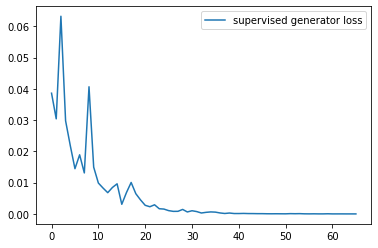

In [11]:
plt.plot(supervised_glosses, label='supervised generator loss')
plt.legend()
plt.show()

In [14]:
## Unsupervised learning

from tqdm.notebook import tqdm
from torch.distributions import Categorical

for epoch in range(35):
    for images, labels in tqdm(train_loader, position=0, leave=False):
        noise = torch.randn(M,200,1,1).to(device)
        images = images.float().to(device)
        images = torch.unsqueeze(images,1)
       
        # train C
        optimizators['C'].zero_grad()

        fake = generator(noise)
        fake = (fake+1)/2
        
        # generate fake images
#         for fidx in range(fake.shape[0]):
#             fake[fidx] = (fake[fidx]-fake[fidx].min())/(fake[fidx].max()-fake[fidx].min())
        
        
        out_real = classifier(images)
        out_fake = classifier(fake)
        
        H_X = Categorical(probs = torch.mean(softmax(out_real),dim=0)).entropy()
        
        E_X = 0;
        for ridx in range(out_real.shape[0]):
            E_X += Categorical(probs = softmax(out_real)[ridx]).entropy()
        E_X /= M;

        E_G = 0;
        for fidx in range(out_fake.shape[0]):
            E_G += Categorical(probs = softmax(out_fake)[fidx]).entropy()
        E_G /= M;
      
        H_G = Categorical(probs = torch.mean(softmax(out_fake),dim=0)).entropy()
        
        loss_c = abs( H_X - E_X + E_G)
        loss_c.backward()
#        torch.nn.utils.clip_grad_norm_(classifier.parameters(), 1)
        optimizators['C'].step()

        losses['C'].append(loss_c.item())
        # don't forget to use item
        
        # train G
        optimizators['G'].zero_grad()

        noise = torch.randn(M,200,1,1).to(device)      
        fake = generator(noise)
        fake = (fake+1)/2
#         for fidx in range(fake.shape[0]):
#             fake[fidx] = Normalize(fake[fidx])
        classifier.eval()
        out_fake = classifier(fake)
        classifier.train()
        
        E_G = 0;
        for fidx in range(out_fake.shape[0]):
            E_G += Categorical(probs = softmax(out_fake)[fidx]).entropy()
        E_G /= M;
      
        H_G = Categorical(probs = torch.mean(softmax(out_fake),dim=0)).entropy()
        
        loss_g = abs( -H_G + E_G)
#        loss_g = E_G

        loss_g.backward()
#        torch.nn.utils.clip_grad_norm_(generator.parameters(), 1)

        optimizators['G'].step()
        
        losses['G'].append(loss_g.item())
    print('epoch #', epoch)
    print(loss_g.item())
    

  0%|          | 0/66 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
# torch.save(generator.state_dict(),'generator.weights')
# torch.save(classifier.state_dict(),'classifier.weights')

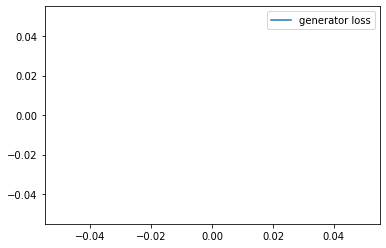

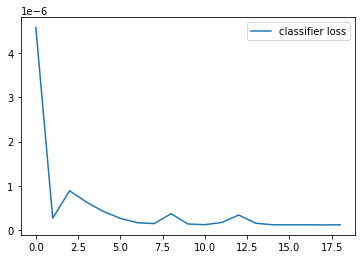

In [16]:
import matplotlib.pyplot as plt
plt.plot(losses['G'][1000:], label='generator loss')
plt.legend()
plt.show()

plt.plot(losses['C'], label='classifier loss')
plt.legend()
plt.show()

In [17]:
generator.load_state_dict(torch.load('generator.weights', map_location=device))
classifier.load_state_dict(torch.load('classifier.weights', map_location=device))

<All keys matched successfully>

(64, 64)
torch.Size([1, 1, 64, 64])
tensor([[1.1586e-10, 2.8100e-11, 1.0000e+00, 2.0959e-10]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[8.0359e-08, 7.2243e-08, 8.2506e-10, 1.0000e+00]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


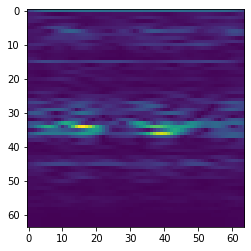

In [18]:
orig = bearing_dataset.getimgs(3)[12]
plt.imshow(orig)
print (orig.shape)
orig = torch.unsqueeze(torch.from_numpy(orig),0)
orig = torch.unsqueeze(orig,0).float()
print (orig.shape)
out = classifier(orig.to(device))
print(softmax(out))
out = supervised_classifier(orig.to(device))
print(softmax(out))


tensor(0.9997, device='cuda:0')
tensor(1.0000, device='cuda:0')
unsupervised out: tensor([[2.6549e-06, 9.9997e-01, 6.7602e-07, 3.0065e-05]], device='cuda:0')
supervised out: tensor([[7.5792e-09, 1.6118e-09, 1.0000e+00, 5.1432e-09]], device='cuda:0')


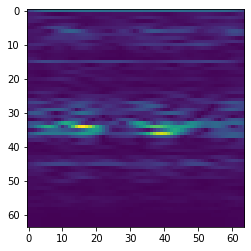

In [19]:
supervised_classifier.eval()
classifier.eval()

with torch.no_grad():
    r=0
    while r<0.9999:
        noise = torch.randn(1,200,1,1)
        emb = generator(noise.to(device))
        for fidx in range(emb.shape[0]):
            emb[fidx] = Normalize(emb[fidx])
        emb = Normalize(emb)
        out = supervised_classifier(emb)
        if softmax(out).max() > r:
            r = softmax(out).max()
            print(r)
            
        

    plt.imshow(emb.cpu().squeeze(0).squeeze(0).detach().numpy())
    print('unsupervised out:', softmax(out))

    supervised_out =  classifier(emb)
    print('supervised out:', softmax(supervised_out))

plt.imshow(orig.squeeze())


tensor(1.0000, device='cuda:0')
supervised out: tensor([[1.7909e-06, 9.9998e-01, 8.0254e-07, 1.3222e-05]], device='cuda:0')
torch.Size([1, 1, 64, 64])
unsupervised out: tensor([[1.4665e-10, 8.2823e-11, 1.0000e+00, 3.8315e-10]], device='cuda:0')


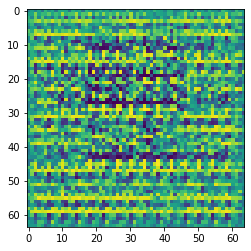

In [24]:
supervised_classifier.eval()
classifier.eval()

with torch.no_grad():
    r=0
    while r<0.9999:
        noise = torch.randn(1,200,1,1)
        emb = generator(noise.to(device))
        for fidx in range(emb.shape[0]):
            emb[fidx] = Normalize(emb[fidx])
        emb = Normalize(emb)
        out = supervised_classifier(emb)
        if softmax(out).max() > r:
            r = softmax(out).max()
            print(r)
            
        

    plt.imshow(emb.cpu().squeeze(0).squeeze(0).detach().numpy())
    print('supervised out:', softmax(out))

    print(emb.shape)
    supervised_out =  classifier(emb)
    print('unsupervised out:', softmax(supervised_out))

    plt.imshow(emb.cpu().squeeze(0).squeeze(0).detach().numpy())


  0%|          | 0/1133 [00:00<?, ?it/s]

/home/lk/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lk/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[Text(0.5, 1.0, 'Bearing data T-SNE projection unsupervised')]

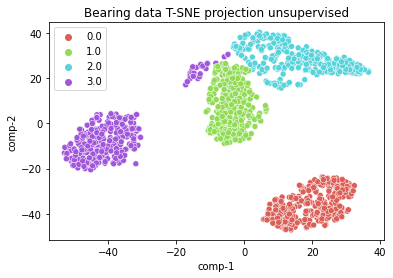

In [58]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd  

tsne = TSNE()
classifier.eval()
latent = []
target = []
for x, y in tqdm(val_loader):
    x = torch.unsqueeze(x,1).float()
    latent.append(classifier.get_latent_features(x.to(device)).detach().to('cpu'))
    target.append(float(y[0]))
latent = torch.cat(latent, dim=0).numpy()
tsne_latent = tsne.fit_transform(latent)
# plt.scatter(tsne_latent[:, 0], tsne_latent[:, 1])
# plt.show()

df = pd.DataFrame()
df["y"] = target
df["comp-1"] = tsne_latent[:,0]
df["comp-2"] = tsne_latent[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 4),
                data=df).set(title="Bearing data T-SNE projection unsupervised") 

  0%|          | 0/1133 [00:00<?, ?it/s]

/home/lk/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lk/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[Text(0.5, 1.0, 'Bearing data T-SNE projection supervised')]

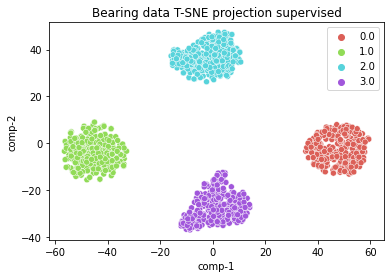

In [59]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd  

tsne = TSNE()
supervised_classifier.eval()
latent = []
target = []
for x, y in tqdm(val_loader):
    x = torch.unsqueeze(x,1).float()
    latent.append(supervised_classifier.get_latent_features(x.to(device)).detach().to('cpu'))
    target.append(float(y[0]))
latent = torch.cat(latent, dim=0).numpy()
tsne_latent = tsne.fit_transform(latent)
# plt.scatter(tsne_latent[:, 0], tsne_latent[:, 1])
# plt.show()

df = pd.DataFrame()
df["y"] = target
df["comp-1"] = tsne_latent[:,0]
df["comp-2"] = tsne_latent[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 4),
                data=df).set(title="Bearing data T-SNE projection supervised") 